In [2]:
from google.colab import drive


drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction

/content/gdrive/My Drive/Colab Notebooks/project_paylocity/ashrae-energy-prediction


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from collections import Counter
import datetime
import seaborn as sns

In [5]:
weather_train = pd.read_csv('weather_train.csv')
train = pd.read_csv('train.csv')
building_metadata = pd.read_csv('building_metadata.csv')


In [20]:
train.head(2)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0


In [43]:
train['building_id'].nunique()

1449

In [44]:
weather_train.head(2)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5


In [45]:
building_metadata.head(2)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN


In [47]:
#so, building_metadata and train can be joined to get site id information, which later gives site id weather data from weather_train.csv
#however, all this should be after taking care of missing data

In [38]:
#meter is {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

In [39]:
#aim is to predict on meter_reading and evaluate on the metric

In [11]:
train.isnull().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [12]:
building_metadata.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [31]:
weather_train.isnull().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

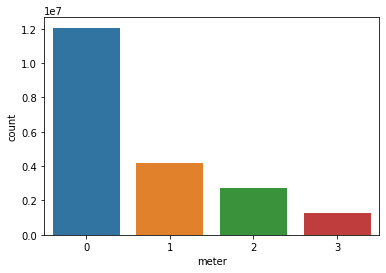

In [28]:
sns.countplot(x="meter", data=train)

In [29]:
#we can use different models for different meters or the same model for all meters

In [34]:
def missing_stat(df):    
    statistics = pd.DataFrame(df.isnull().sum()).reset_index()
    statistics.columns=['column_name',"missing_values"]
    statistics['Total_rows'] = df.shape[0]
    statistics['missing_percent'] = round((statistics['missing_values']/statistics['Total_rows'])*100,2)
    return statistics

In [35]:
missing_stat(weather_train)

,column_name,missing_values,Total_rows,missing_percent
0,site_id,0,139773,0.00
1,timestamp,0,139773,0.00
2,air_temperature,55,139773,0.04
3,cloud_coverage,69173,139773,49.49
4,dew_temperature,113,139773,0.08
5,precip_depth_1_hr,50289,139773,35.98
6,sea_level_pressure,10618,139773,7.60
7,wind_direction,6268,139773,4.48
8,wind_speed,304,139773,0.22


In [37]:
#weather data should have 16 * 24 * 366(leap) rows - > 140544

In [36]:
missing_stat(building_metadata)

,column_name,missing_values,Total_rows,missing_percent
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


In [40]:
weather_train.head(2)

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5


In [56]:
weather_train['site_id'].nunique()

16

In [41]:
from tqdm import tqdm

In [60]:
time_format = "%Y-%m-%d %H:%M:%S"
start_date = datetime.datetime.strptime(weather_train['timestamp'].min(),time_format)
end_date = datetime.datetime.strptime(weather_train['timestamp'].max(),time_format)
total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]



In [61]:
missing_hours = []
for site_id in tqdm(range(16)):
    site_hours = np.array(weather_train[weather_train['site_id'] == site_id]['timestamp'])
    new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
    new_rows['site_id'] = site_id
    weather_train = pd.concat([weather_train,new_rows])

weather_train = weather_train.reset_index(drop=True)  

100%|██████████| 16/16 [02:14<00:00,  8.39s/it]


In [63]:
missing_stat(weather_train)

,column_name,missing_values,Total_rows,missing_percent
0,site_id,0,140544,0.00
1,timestamp,0,140544,0.00
2,air_temperature,826,140544,0.59
3,cloud_coverage,69944,140544,49.77
4,dew_temperature,884,140544,0.63
5,precip_depth_1_hr,51060,140544,36.33
6,sea_level_pressure,11389,140544,8.10
7,wind_direction,7039,140544,5.01
8,wind_speed,1075,140544,0.76


In [64]:
weather_train["datetime"] = pd.to_datetime(weather_train["timestamp"])
weather_train["day"] = weather_train["datetime"].dt.day
weather_train["week"] = weather_train["datetime"].dt.isocalendar().week
weather_train["month"] = weather_train["datetime"].dt.month

In [65]:
weather_df = weather_train.copy()
weather_df = weather_df.set_index(['site_id','day','month'])


In [66]:
air_values = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(), columns = ['air_temperature'])
weather_df.update(air_values,overwrite=False)

due = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(), columns = ['dew_temperature'])
weather_df.update(due,overwrite=False)

wind = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(), columns = ['wind_direction'])
weather_df.update(wind,overwrite=False)

wind_speed = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(), columns = ['wind_speed'])
weather_df.update(wind_speed,overwrite=False)

weather_df['cloud_coverage'].fillna(method = 'ffill', inplace=True)
weather_df['sea_level_pressure'].fillna(method = 'ffill', inplace=True)
weather_df['precip_depth_1_hr'].fillna(method = 'ffill', inplace=True)
weather_df['precip_depth_1_hr'].fillna(0, inplace=True)

In [67]:
missing_stat(weather_df)

,column_name,missing_values,Total_rows,missing_percent
0,timestamp,0,140544,0.0
1,air_temperature,0,140544,0.0
2,cloud_coverage,0,140544,0.0
3,dew_temperature,0,140544,0.0
4,precip_depth_1_hr,0,140544,0.0
5,sea_level_pressure,0,140544,0.0
6,wind_direction,0,140544,0.0
7,wind_speed,0,140544,0.0
8,datetime,0,140544,0.0
9,week,0,140544,0.0


In [68]:
weather_df = weather_df.reset_index()
weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)

In [69]:
missing_stat(building_metadata)

,column_name,missing_values,Total_rows,missing_percent
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


In [70]:
building_metadata2 = building_metadata.copy()

building_metadata['floor_count'] = building_metadata['floor_count'].fillna(building_metadata['floor_count'].median())
building_metadata['year_built'] = building_metadata['year_built'].fillna(building_metadata['year_built'].median())

In [74]:
missing_stat(building_metadata)

,column_name,missing_values,Total_rows,missing_percent
0,site_id,0,1449,0.0
1,building_id,0,1449,0.0
2,primary_use,0,1449,0.0
3,square_feet,0,1449,0.0
4,year_built,0,1449,0.0
5,floor_count,0,1449,0.0


In [72]:
# weather_df.to_csv('weather_df_may.csv', index = False)
# building_metadata.to_csv('building_metadata_may.csv', index = False)

In [6]:
weather_train = pd.read_csv('weather_df_may.csv')
building_metadata = pd.read_csv('building_metadata_may.csv')

In [73]:
# we have checked for missing values'; now we can look for abnormal data figures

In [9]:
train_orig = train.copy()

In [10]:
train = train.merge(building_metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [11]:
train["timestamp"] = pd.to_datetime(train["timestamp"])

In [12]:
train.head(3)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,3.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,3.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,3.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [79]:
#maybe abnormal buildings, or sites, or timestamps

In [17]:
train = train[train.site_id.isin([0,11,12,13])]

In [18]:
train_orig.shape

(20216100, 4)

In [19]:
train.shape

(4223793, 16)

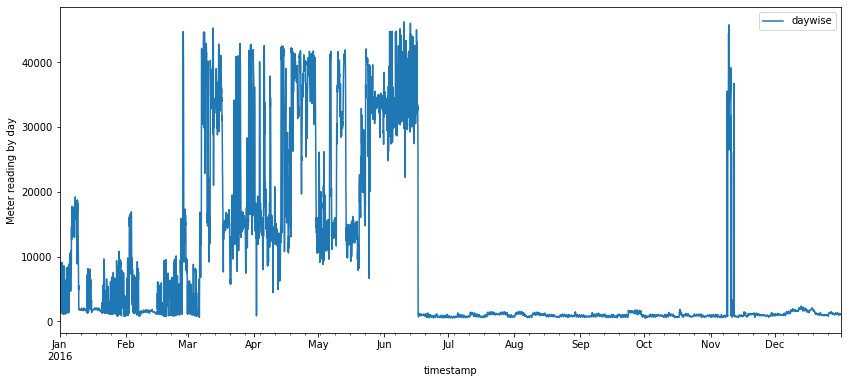

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
train[['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax = axes, label = 'daywise').set_ylabel('Meter reading by day')
axes.legend()

In [21]:
#avg meter_reading for some sites

In [39]:
# so check by site

In [41]:
train['site_id'].nunique()

4

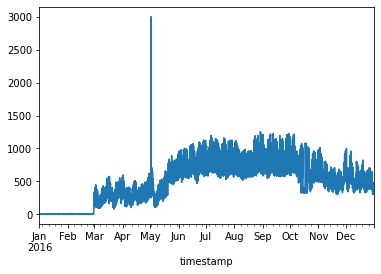

In [45]:
train[train['site_id'] == 0][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot()

In [49]:
list(train['site_id'].unique())

[0, 11, 12, 13]

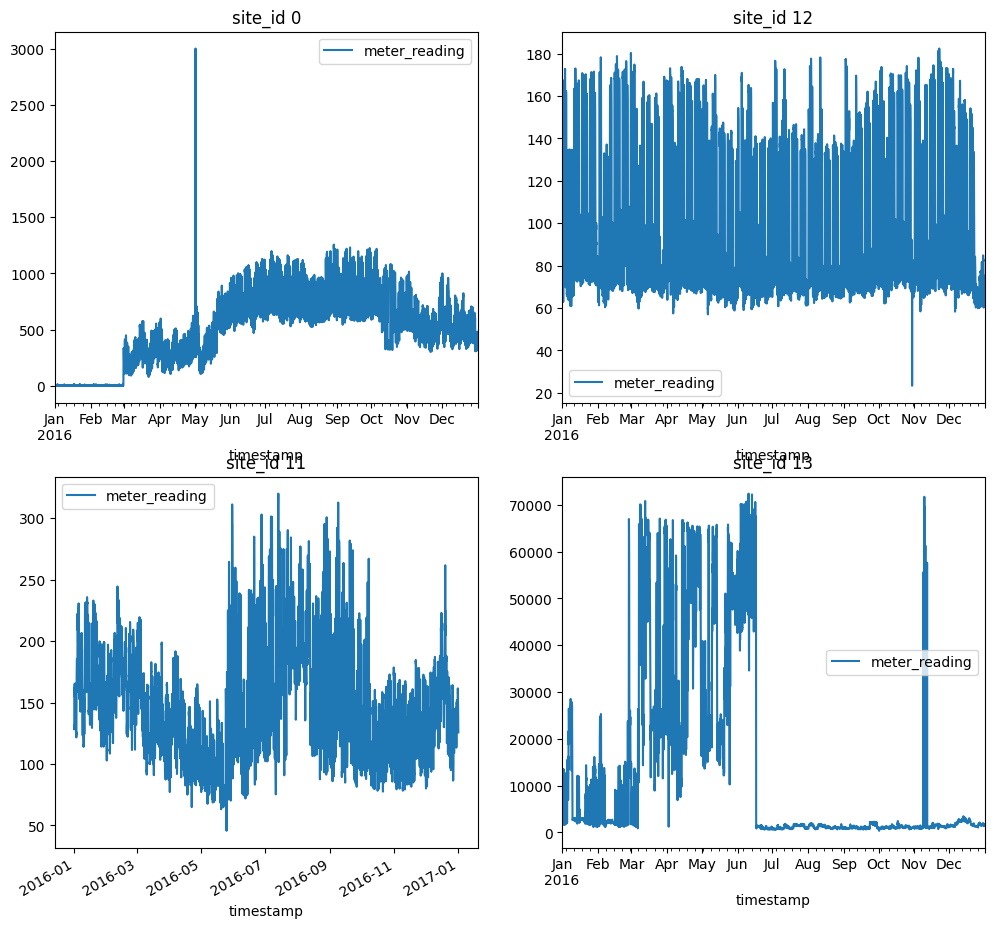

In [56]:
fig, axes = plt.subplots(2,2,figsize=(12, 12), dpi=100)
for f, i in enumerate(train['site_id'].unique()):
    train[train['site_id'] == i][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax = axes[f%2][f//2])
    axes[f%2][f//2].legend()
    axes[f%2][f//2].set_title('site_id {}'.format(i));

In [66]:
#site id 0 and 13 have varying values
#site 13 resembles the overall dataset; but we may have issues

In [69]:
#meter is {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}

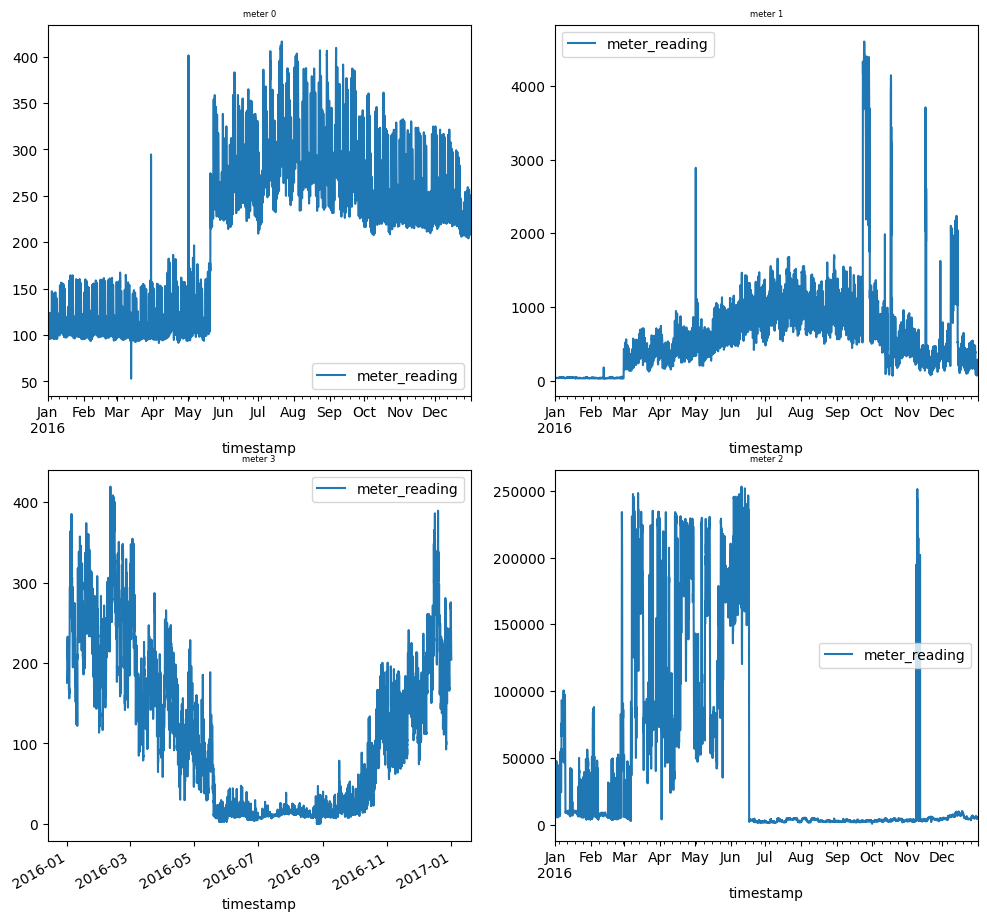

In [68]:
fig, axes = plt.subplots(2,2,figsize=(12, 12), dpi=100)
for f, i in enumerate(train['meter'].unique()):
    train[train['meter'] == i][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax = axes[f%2][f//2])
    axes[f%2][f//2].legend()
    axes[f%2][f//2].set_title('meter {}'.format(i), fontsize = 6);

In [61]:
#time series data should be somewhat uniform, so there are issues in the dataset

In [70]:
#so there are buildings in meter 2 site 13 that is creating an issue

In [72]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,3.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,3.0,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [73]:
train['primary_use'].nunique()

14

In [78]:
train[train['site_id'] == 13]['primary_use'].nunique()

13

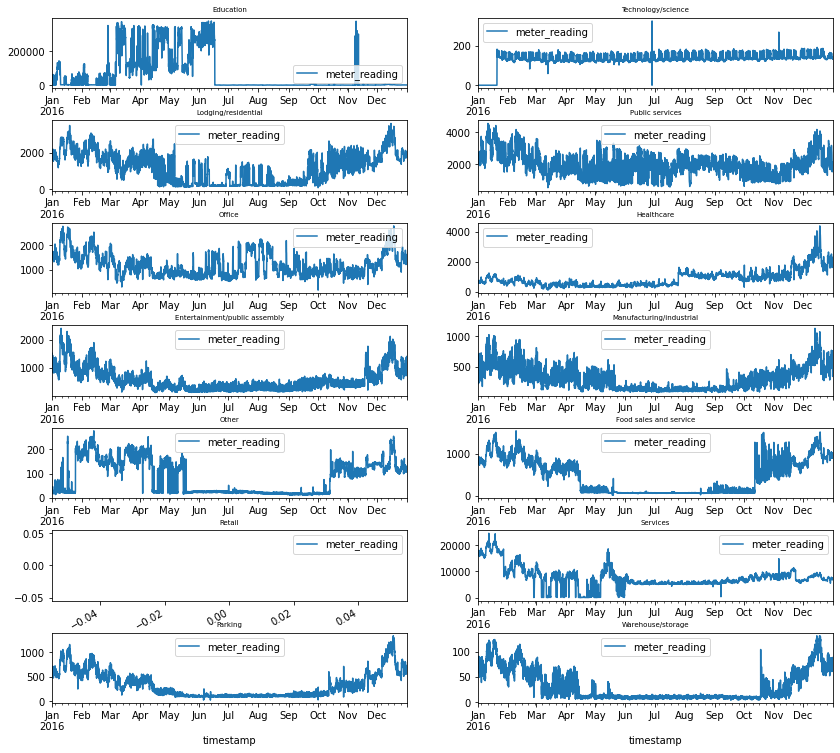

In [83]:
fig, axes = plt.subplots(7,2,figsize=(14,14))
for i, use in enumerate(train['primary_use'].unique()):
    try:
        train[(train['site_id'] == 13) & (train['primary_use'] == use)][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax=axes[i%7][i//7]);
        axes[i%7][i//7].legend();
    except TypeError:
        pass
    axes[i%7][i//7].set_title(use, fontsize=7);
    plt.subplots_adjust(hspace=0.45)

In [84]:
#education has the issue

In [86]:
train[(train['site_id'] == 13) & (train['primary_use'] == 'Education')&(train['meter']==2)]['building_id'].nunique()

17

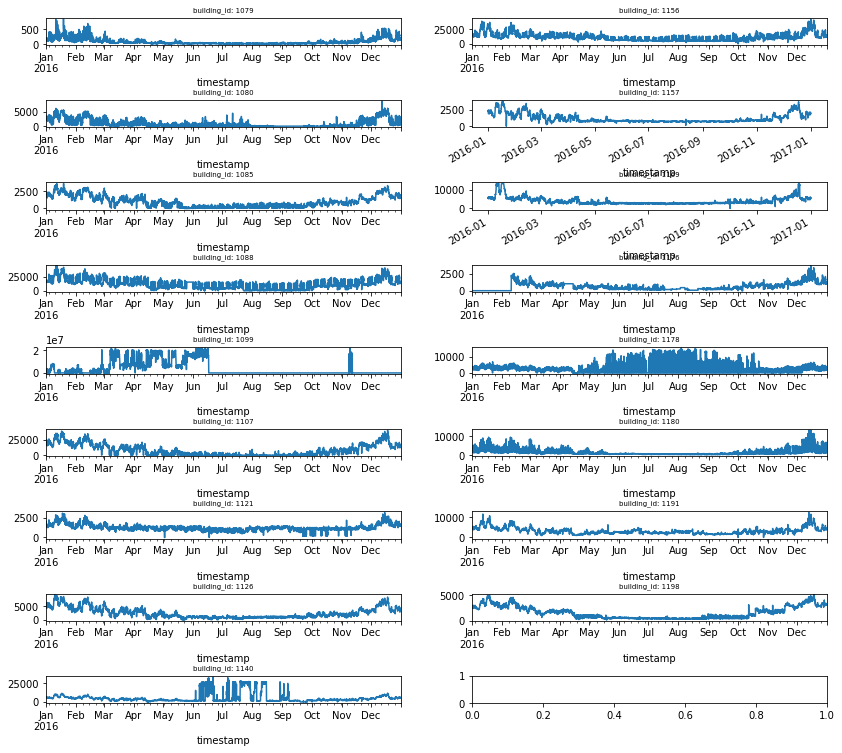

In [91]:
fig, axes = plt.subplots(9,2,figsize=(14, 14))
for i, building in enumerate(train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2)]['building_id'].unique()):
    train[(train['site_id'] == 13) & (train['primary_use'] == 'Education') & (train['meter'] == 2) & (train['building_id'] == building)][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax=axes[i%9][i//9]);

    axes[i%9][i//9].set_title('building_id: ' + str(building), fontsize=7);
    plt.subplots_adjust(hspace=2)

In [92]:
#so, building 1099 has issues

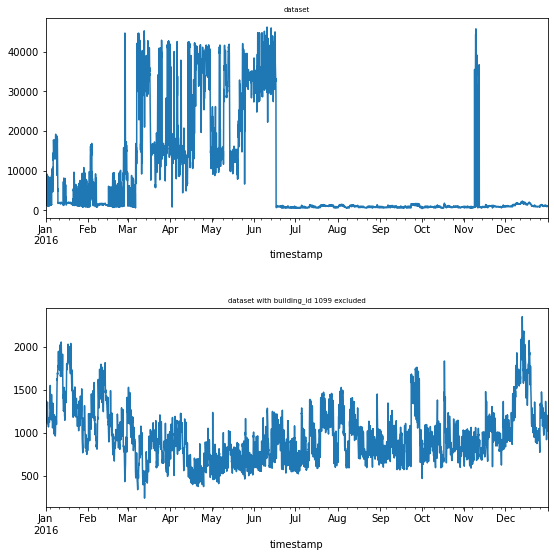

In [95]:
fig, axes = plt.subplots(2,1,figsize=(9, 9))


train[['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax=axes[0]);

train[~((train['meter'] == 2) & (train['building_id'] == 1099))][['timestamp', 'meter_reading']].groupby('timestamp')['meter_reading'].mean().plot(ax=axes[1]);

axes[0].set_title('dataset', fontsize=7);
axes[1].set_title('dataset with building_id 1099 excluded', fontsize=7);
plt.subplots_adjust(hspace=0.45)

In [97]:
train.shape

(4223793, 16)

In [98]:
train[~((train['meter'] == 2) & (train['building_id'] == 1099))].shape

(4215009, 16)

In [99]:
train_preprocessed = train[~((train['meter'] == 2) & (train['building_id'] == 1099))]

In [100]:
train.to_csv('train_may.csv', index=False)
train_preprocessed.to_csv('train_preprocessed_may.csv', index=False)